# Predicting Trimethoprim resistance in DHFR<sub>pj</sub>



This notebook demonstrates how ROBUST descriptors can be used to inform if a mutant variant of a protein is less succebtible to a specific drug.

This is achieved using a relatively simpel classification model. The classifiers area under the reciever operating characteristic curve was 0.75 &pm; 0.15, indicating that resistant variants show distinct differencesin in physical interactions and dynamics. 

The notebook is sectioned into initial exploratory analysis and model training and evaluation.

## Module Imports

In [1]:
import os
import json

import numpy as np
import pandas as pd

from scipy import interp
from scipy.stats import probplot, norm, pearsonr

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


Default matplotlib parameters are provided in a separate json file:

In [2]:
%matplotlib inline
with open('.rcparams.json', 'r') as fh:
    matplotlib.rcParams.update(json.load(fh))

## Load data

Let first load the data.
For this project a large number of complexes have been simulated, however we restrict initial analysis TMP/DHFR<sub>pj</sub> variants from Queener et al.

In [3]:
datadir = os.path.abspath('./data')

dataset = pd.read_csv(os.path.join(datadir, 'dataset.csv'), sep=',', index_col=0)


dG = dataset.groupby('name').agg({'dG': 'first'})

labels = dataset.groupby('name').agg({'label': 'first'})
# Set PJQ18 to resistant
labels.loc['PJQ18', 'label'] = 'resistant'

eval_set = labels.index # The final set of structures to evaluate

n_variants = len(labels)

In [4]:
X_vdw = pd.read_csv(os.path.join(datadir, 'data_vdw_merged.csv'), sep=',', index_col=0).loc[eval_set, :]

X_vdw.drop(X_vdw.columns[X_vdw.mean()>-0.1], axis=1, inplace=True)

# Rename feature labels (i.e. we don't need chain IDs)
columns = []
for c in X_vdw.columns:
    resids = c.split(' - ')
    cid = '$\\rm vdW\ {}-{}$'.format(*[r.split(':')[0] for r in resids])
    columns.append(cid)

X_vdw.columns = columns
    

#X_vdw.columns = ['vdw '+ c for c in X_vdw.columns]

X_hbond = pd.read_csv(os.path.join(datadir, 'data_hbond_merged.csv'), sep=',', index_col=0).loc[eval_set]

# Rename feature labels (i.e. we don't need chain IDs)
columns = []
for c in X_hbond.columns:
    resids = c.split(':')
    if resids[1] == 'L': # Ligand indicated by chain id L
        cid = '$\\rm Hbond\ {}_{{{}}}-{}_{{{}}}$'.format('TMP',resids[5], resids[4], resids[6])
    elif resids[2] == 'L':
        cid = '$\\rm Hbond\ {}_{{{}}}-{}_{{{}}}$'.format(resids[3],resids[5], 'TMP', resids[6])
    else:
        cid = '$\\rm Hbond\ {}_{{{}}}-{}_{{{}}}$'.format(resids[3],resids[5], resids[4], resids[6]) # resnum1:atom1-resnum2:atom2
    columns.append(cid)

X_hbond.columns = columns

#X_hbond.columns = ['hbond '+ c for c in X_hbond.columns]


X_rms = pd.read_csv(os.path.join(datadir, 'data_rms_merged.csv'), sep=',', index_col=0).loc[eval_set]

# Rename feature labels (i.e. we don't need chain IDs)
columns = []
for c in X_rms.columns:
    if c == 'mean_rmsd':
        cid = '$\\rm rmsd$'
    else:
        type_, resnum = c.split(':')
        if type_ == 'LIG': # If ligand it is the atom number not residue number
            cid = '$\\rm rmsf\ TMP_{{{}}}$'.format(resnum)
        else:
            cid = '$\\rm rmsf\ C\\alpha_{{{}}}$'.format(resnum)
    columns.append(cid)

X_rms.columns = columns

#X_rms.columns = ['rms '+ c for c in X_rms.columns]

X_merged = pd.concat([X_rms, X_vdw, X_hbond], axis=1)

X = np.array(X_merged)

## Distribution of TMP binding affinity.
Lets take a look at the most important variable, the dbinding affinity of TMP against DHFR<sub>pj</sub>

In [5]:
dG.describe()

,dG
count,20.000000
mean,-9.198504
std,0.980427
min,-10.412035
25%,-9.916003
50%,-9.419213
75%,-8.840438
max,-6.617862


/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


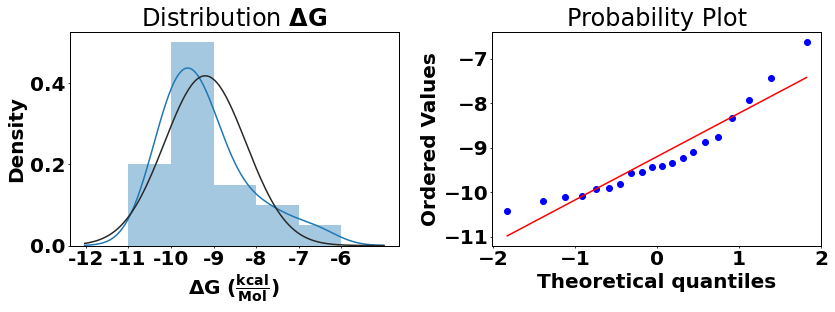

In [6]:
bins=np.arange(-12,-5, 1)
plt.figure(figsize=(12,8))

ax1 = plt.subplot(2,2,1)
plt.title('Distribution $\\rm \\Delta G$')
sns.distplot(dG , fit=norm, bins=bins,)
plt.xlabel('$\\rm \\Delta G\ (\\frac{kcal}{Mol})$')
plt.xticks(ticks=bins, labels=map(str, bins))

ax2 = plt.subplot(2,2,2)
_=probplot(np.array(dG).reshape(-1), plot=plt)
plt.tight_layout()
plt.show()

This does not bode well for regression, the dataset shows long tails and half of the binding affinities fall within a ~1 kcal/Mol window. Luckily for us the authors have also reported which variants show significant change in TMP K<sub>i</sub>.

In the dataset these structures are labeled either susceptible or resistant depending on whether TMP binding affinity is significantly different from Wildtype.

Lets take a look at the distribution of binding affinities as a function of resistance:

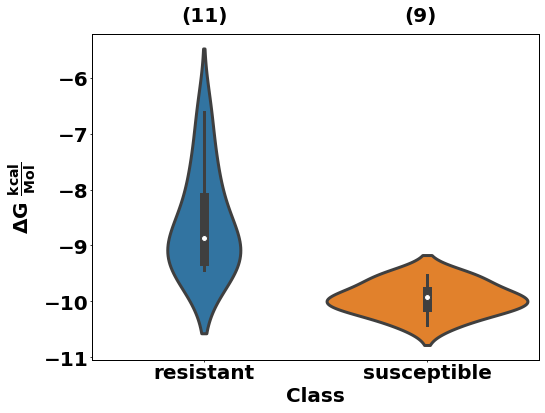

In [7]:
# digitize labels
y = np.array(labels.label=='susceptible').astype(int)

plt.figure(figsize=(8,6))
ax = sns.violinplot(x=y, y=np.array(dG).reshape(-1), linewidth=3, width=0.9)
ax.set_xlabel('Class')
ax.set_ylabel('$\\bf \\Delta G\ \\frac{kcal}{Mol}$', weight='bold')
ax.set_xticklabels(['resistant', 'susceptible'], weight='bold')
ax.text(-0.1, -5, '({})'.format((y==0).sum()))
ax.text(0.9, -5, '({})'.format(y.sum()))
plt.savefig('./figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

With 2 almost equaly sized classes, classification of variants in **suscebtible** and **resistant** should be feasible.

There are a number or resistant variants with &Delta;G similar to the susceptible variants. 

These might be difficult to distinguish from the susceptible variants, however, highly resistant variants should be readily distinguishable.


## Visualizing interactions

Let's first take a look at the raw data

In [8]:
mutations = dataset.groupby('name').agg({'mut1': 'first', 'mut2': 'first'})
rmsf_data = pd.DataFrame(index=dG.sort_values(by='dG').index, columns=list(range(3, 207)))

for name in dataset.name.unique():
    data = pd.DataFrame(columns=list(range(3, 207)))
    for index in dataset.index[dataset.name==name]:
        fn = dataset.loc[index, 'trj_rms']
        rep = dataset.rep[index]
        with open(fn) as fh:
            data_dict = json.load(fh)
        for out in data_dict:
            if out['name'] == 'calpha rmsf':
                data.loc[rep, [aid[1] for aid in out['atom_ids']]] = out['results']
    rmsf_data.loc[name,:] = data.mean(axis=0)

rmsf_data = rmsf_data.astype(float)

In [9]:
vdw = pd.read_csv(os.path.join(datadir, 'data_vdw_merged.csv'), sep=',', index_col=0).loc[eval_set, :]
vdw_ligand = pd.DataFrame(index=dG.sort_values(by='dG').index, columns=list(range(3, 207)))
for c in vdw.columns:
    r1, r2 = c.split(' - ')
    if r1 == 'LIG':
        resnum2, chain2 = r2.split(':')
        if chain2 == 'A':
            if vdw[c].min()>-0.1:
                continue
            vdw_ligand.loc[:,int(resnum2)] = np.abs(vdw[c])
#vdw_ligand.drop(vdw_ligand.columns[vdw_ligand.min()>-0.1], axis=1, inplace=True)
vdw_ligand.fillna(0, inplace=True)

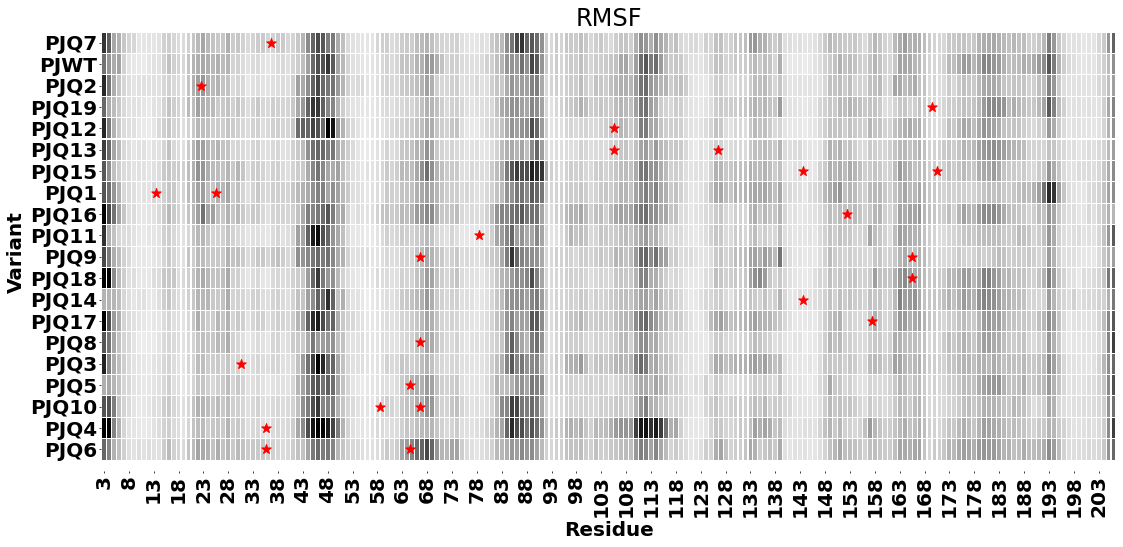

In [10]:
plt.figure(figsize=(16, 8))
ax = sns.heatmap(rmsf_data, cmap='binary', linewidths=0.1, vmin=0., vmax=3, cbar=False)
for i, name in enumerate(rmsf_data.index):
    if name != 'PJWT':
        res1 = int(mutations.loc[name, 'mut1'].split(':')[0])
        plt.scatter(res1-3, i+0.5, color='red', marker='*', s=100)
        if not mutations.isna().loc[name, 'mut2']:
            res2 = int(mutations.loc[name, 'mut2'].split(':')[0])
            plt.scatter(res2-3, i+0.5, color='red', marker='*', s=100)

ax.set_ylim((len(rmsf_data)+0.5, 0))

ax.set_xlabel('Residue')
ax.set_ylabel('Variant')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('RMSF')
plt.tight_layout()
plt.show()

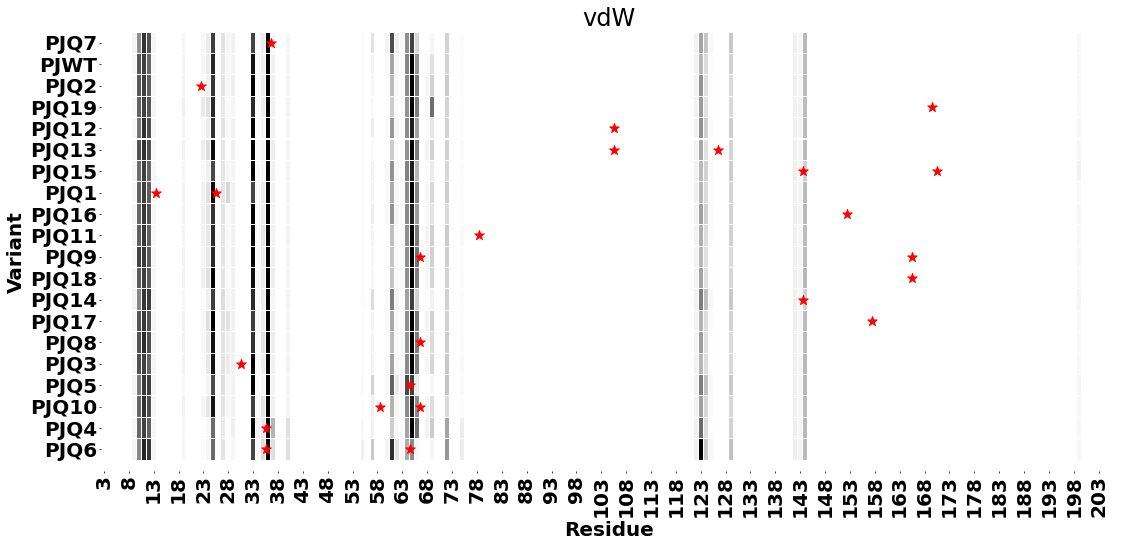

In [11]:
plt.figure(figsize=(16, 8))
ax = sns.heatmap(vdw_ligand, cmap='binary', linewidths=0.1, vmin=0., vmax=3, cbar=False)
for i, name in enumerate(rmsf_data.index):
    if name != 'PJWT':
        res1 = int(mutations.loc[name, 'mut1'].split(':')[0])
        plt.scatter(res1-3, i+0.5, color='red', marker='*', s=100)
        if not mutations.isna().loc[name, 'mut2']:
            res2 = int(mutations.loc[name, 'mut2'].split(':')[0])
            plt.scatter(res2-3, i+0.5, color='red', marker='*', s=100)

ax.set_ylim((len(rmsf_data)+0.5, 0))

ax.set_xlabel('Residue')
ax.set_ylabel('Variant')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.title('vdW')
plt.tight_layout()
plt.show()

## Classifier

Our dataset consists of 20 datapoints (n) with 2487 features (p) each. Thus prior to classification we should reduce the number of features so that n &gt; p. This means we either have to select features or project them on a lower dimensional space (e. g. PCA).

### Comparing different feature selection schemes

We want to do a comparison of different feature selection techniques, the goal here is not strictly to find the absolutely best model, we'd need an independent test set and thus additional data, but we want to see if one method stands out, as the evaluation below shows is not the case.

In [12]:
cv = 4
scoring = 'f1'
np.random.seed(100)

#### 1. Dimensionality reduction with PCA

In [13]:
clf_pca = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA()),
                ('clf', LogisticRegression(penalty='none',solver='saga', max_iter=10000))])

param_clf_pca = {
    'pca__n_components': [2,3,4,5,10]}

search = GridSearchCV(clf_pca, param_clf_pca, cv=cv, scoring=scoring, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.700):
{'pca__n_components': 2}


#### 2. Dimensionality reduction by selecting K best features (ANOVA F-value)

In [14]:
clf_anova = Pipeline([('scaler', StandardScaler()),
                ('kbest', SelectKBest(score_func=f_classif)),
                ('clf', LogisticRegression(penalty='none',solver='saga', max_iter=10000))])

param_clf_anova = {
    'kbest__k': [2,3,4,5,10]}

search = GridSearchCV(clf_anova, param_clf_anova, cv=cv, scoring=scoring, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.650):
{'kbest__k': 10}


/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:115: UserWarning: Features [2448 2449 2450 2451 2452 2453 2454 2455 2456 2457 2458 2459 2460 2461
 2462 2463 2464 2465 2466 2467 2468 2469 2470 2471 2472 2473 2474 2475
 2476 2477 2478 2479 2480 2481 2482 2483 2484 2485 2486] are constant.
  UserWarning)
/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/sklearn/feature_selection/_univariate_selection.py:116: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


#### 3. Dimensionality reduction by selecting K best features (Mutual info)

In [15]:
clf_minf = Pipeline([('scaler', StandardScaler()),
                ('kbest', SelectKBest(score_func=mutual_info_classif)),
                ('clf', LogisticRegression(penalty='none',solver='saga', max_iter=10000))])

param_clf_minf = {
    'kbest__k': [2,3,4,5,10,]
}

search = GridSearchCV(clf_minf, param_clf_minf, cv=cv, scoring=scoring, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.700):
{'kbest__k': 4}


#### 4. Lasso Regression

In [16]:
        
clf_l1 = Pipeline([('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1',solver='saga', max_iter=10000))])

param_clf_l1 = {
    'clf__C': [0.1, 1, 2, 5, 10]}

search = GridSearchCV(clf_l1, param_clf_l1, cv=cv, scoring=scoring, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.667):
{'clf__C': 5}


#### 5. Elastic net Regression

In [17]:
        
clf_en = Pipeline([('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='elasticnet',solver='saga', max_iter=10000))])

param_clf_en = {
    'clf__l1_ratio': np.linspace(0.1, 0.9, 10)
}

search = GridSearchCV(clf_en, param_clf_en, cv=cv, scoring=scoring, n_jobs=-1)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.667):
{'clf__l1_ratio': 0.18888888888888888}


### Evaluation


To make the most of our limited data we use stratified crossvalidation, spliting the dataset into two equaly sized subsets. Each subsets are contains 5 susceptible and 5 resistant variants used once for training and once for testing. This process is repeated 50 times on random permutations of the dataset.

Note, that Standardization and PCA is performed on the trainingset and then applied to the testset.  
This is necesarry because the testset is treated as 10 "unknown" samples. If we would perform standardization and PCA prior to crossvalidation, the testset would no longer be unknown, defeating the purpose of crossvalidation.

In [18]:
n_repeats = 50
n_splits = 2

np.random.seed(666)

clf = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('clf', LogisticRegression(penalty='none',solver='saga', max_iter=10000))])


seeds = np.random.randint(low=1, high=10000, size=n_repeats)

cv_scores = np.zeros((n_repeats, n_splits))

cmatrices = np.zeros((n_repeats, 2, 2))
predicts = np.zeros((n_repeats, n_variants))


tprs = []
aucs = []
score_df = pd.DataFrame(columns=['accuracy', 'precision', 'recall', 'f1_score'])
mean_fpr = np.linspace(0, 1, 100)

for i, seed in enumerate(seeds):
    sskf = StratifiedShuffleSplit(n_splits=n_splits, random_state=seed, test_size=1/n_splits)
    for train, test in sskf.split(X, y):
        clf.fit(X[train], y[train])
        y_predict = clf.predict(X[test])
        probas_ = clf.predict_proba(X[test])
        
        cmatrices[i] = confusion_matrix(y[test], y_predict)
        predicts[i, test] = y_predict
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        score_df.loc[i, 'accuracy'] = accuracy_score(y[test], y_predict)
        score_df.loc[i, 'precision'] = precision_score(y[test], y_predict)
        score_df.loc[i, 'recall'] =  recall_score(y[test], y_predict)
        score_df.loc[i, 'f1_score'] = f1_score(y[test], y_predict)
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)


/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
score_df.mean()

accuracy     0.650000
precision    0.614833
recall       0.646000
f1_score     0.605053
dtype: float64

In [20]:
score_df.std()

accuracy     0.137396
precision    0.190403
recall       0.261440
f1_score     0.191317
dtype: float64

Let's plot the results:

/opt/usershared/software/schrodinger.ve/lib/python3.6/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_anchor" which is no longer supported as of 3.3 and will become an error two minor releases later


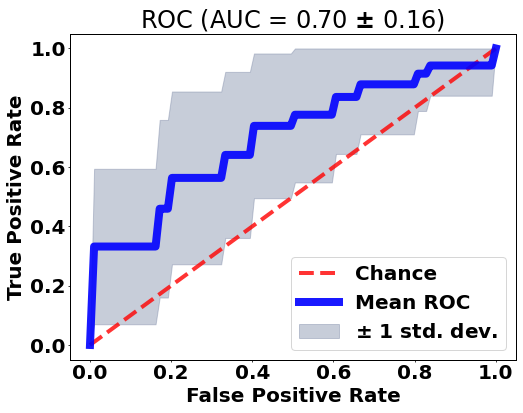

In [21]:
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)

plt.figure(figsize=(8, 6))

plt.subplot()

plt.plot([0, 1], [0, 1], linestyle='--', lw=4, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC',
         lw=8, alpha=.9)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='#7582A1', alpha=.4,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC (AUC = {:.2f} $\pm$ {:.2f})'.format(mean_auc, std_auc))
plt.legend(prop={'weight':'bold'}, loc='lower right')
plt.savefig('./figures/roc_curve.png', dpi=300, bbox_to_anchor='tight')
plt.show()

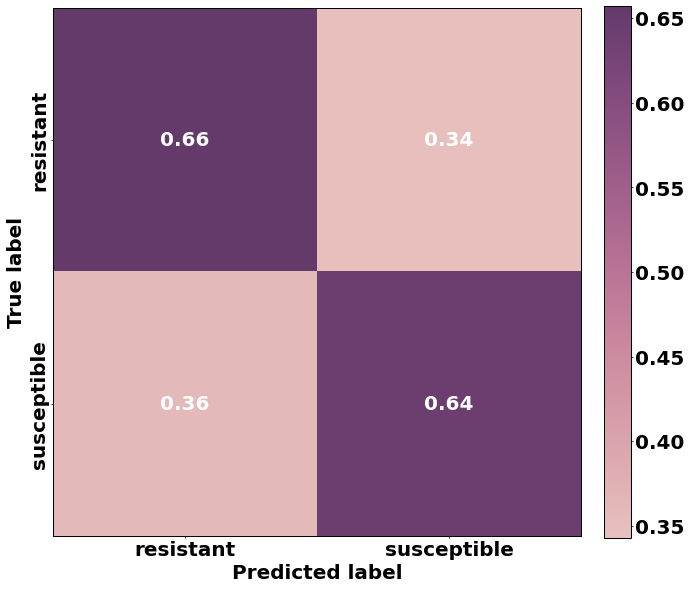

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = cmatrices.sum(axis=0)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
plt.colorbar(im, fraction=0.046, pad=0.04)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=['resistant', 'susceptible'],
       ylabel='True label',
       xlabel='Predicted label')


ax.set_yticklabels(['resistant', 'susceptible'] ,rotation=90, horizontalalignment='right', verticalalignment='center')

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

The classifier can definitely pick up differences in dynamics and interactions between susceptible and resistant variants. It performs quiet well predicting susceptible variants. Finally lets check out the principal component projection of the full dataset:

In [23]:
n_components = 20
pca = PCA(n_components=n_components, )
pc = pca.fit_transform(StandardScaler().fit_transform(X))
pc_df = pd.DataFrame(np.hstack((pc, y.reshape(-1,1), np.array(dG).reshape(-1,1))),
                     columns=['PC{}'.format(x) for x in range(1, n_components+1)]+['class', 'dG'], index=eval_set)



for index in pc_df.index:
    if pc_df.loc[index, 'class']:
        pc_df.loc[index, 'class'] = 'susceptible'
    else:
        pc_df.loc[index, 'class'] = 'resistant'

pc_df.loc[:, 'class_int'] = (pc_df['class']=='resistant').astype(int)

In [24]:
classifier = LogisticRegression(penalty='none',solver='saga', max_iter=10000)
classifier.fit(pc_df[['PC1', 'PC2']], pc_df['class_int'])

y_pred = classifier.predict(pc_df[['PC1', 'PC2']])
accuracy = accuracy_score(pc_df['class_int'], y_pred)
print("Accuracy: {}".format(accuracy * 100))

# View probabilities:
probas = classifier.predict_proba(pc_df[['PC1', 'PC2']])

Accuracy: 85.0


In [25]:
## Predict probabilities

def make_Xgrid(X, samples=100, padding=1):
    if X.shape[-1] != 2:
        raise RuntimeError('Array needs to be for shape: (N,2)')
    xmin, ymin = X.min(axis=0) - padding
    xmax, ymax = X.max(axis=0) + padding

    xx, yy = np.meshgrid(np.linspace(xmin, xmax, samples), np.linspace(ymin, ymax, samples))
    return xx, yy

def point2grid(X, samples=10, padding=1):
    mapping = np.zeros(X.shape)
    for i, x in enumerate(X.T):
        x_min = np.min(x) - padding
        x_max = np.max(x) + padding
        span = (x_max-x_min)/samples
        mapping[:, i] = (x-x_min)/span
    return mapping      

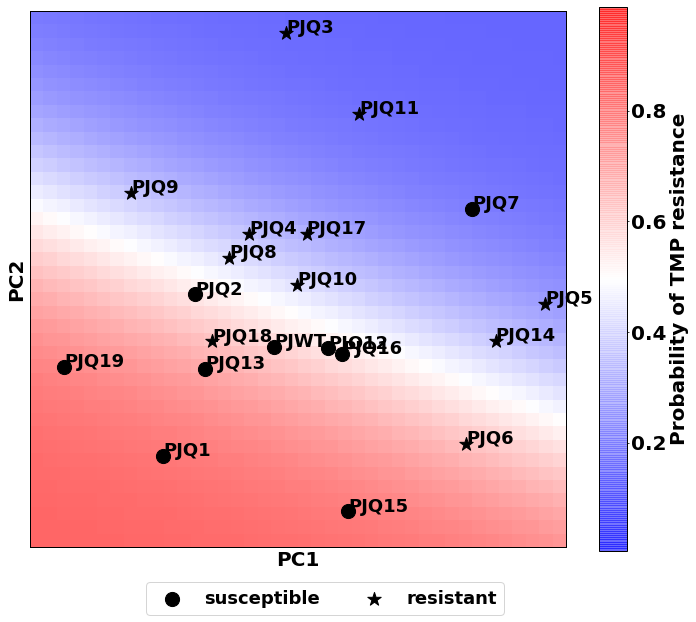

In [26]:
samples = 40

xx, yy = make_Xgrid(pc_df[['PC1', 'PC2']].values, samples=samples, padding=4)
mapping = point2grid(pc_df[['PC1', 'PC2']].values, samples=samples, padding=4)

pgrid = np.zeros((samples,)*2)
for i in range(samples):
    pgrid[i,:] = classifier.predict_proba(np.vstack([xx[i],yy[i]]).T)[:,0]

fig, ax = plt.subplots(figsize=(12,10))
hmap = plt.imshow(pgrid, cmap='bwr', origin='lower', alpha=0.6)

for c, m in zip(['susceptible', 'resistant'], ['o', '*']):
    plt.scatter(*mapping[pc_df['class']==c].T, color='k', marker=m, s=200, label=c)

def label_point(x, y, val, ax):
    a = pd.DataFrame.from_dict({'x': x, 'y': y, 'val': val})
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']), fontsize=18)

label_point(mapping[:,0], mapping[:,1], np.array(pc_df.index), ax)

plt.legend(loc='upper left', fontsize=18, bbox_to_anchor=(0.2, -0.05), ncol=2)


plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xticks([],[])
plt.yticks([],[])
cbar = plt.colorbar(hmap)
cbar.set_alpha(1.0)
cbar.set_label('Probability of TMP resistance')
#plt.legend(loc='best')
plt.savefig('./figures/logit_model_pca.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
X_merged.columns[np.abs(pca.components_[1])>0.05]

Index(['$\rm vdW\ 140-176$', '$\rm vdW\ 180-181$', '$\rm vdW\ 31-34$',
       '$\rm Hbond\ 38_{O}-41_{H}$', '$\rm Hbond\ 172_{OS}-140_{HS}$',
       '$\rm Hbond\ 176_{O}-179_{H}$'],
      dtype='object')

## Plot the distribution of the 6 largest values of the 2nd eigenvector

In [28]:
# Normalize data, for plotting rms/hbond/vdw all on the same axis
X_merged_scaled = pd.DataFrame(StandardScaler().fit_transform(X_merged), index=X_merged.index, columns=X_merged.columns)

# Get the 10 most "discriminant" features
component_df = pd.DataFrame(columns=['PC1', 'PC2', 'labels'])
component_df.loc[:,'PC1'] = np.abs(pca.components_[0]) 
component_df.loc[:, 'PC2'] = np.abs(pca.components_[1])
component_df['labels'] = X_merged.columns

#top10_pc2 = component_df.sort_values(axis=0, by='PC2')['labels'][-10:]
top_pc2 = X_merged.columns[np.abs(pca.components_[1])>0.05]

paired_boxp_df = pd.DataFrame(columns=['val','class', 'feat_label'])

i=0
#for feat_label in top10_pc2:
for feat_label in top_pc2:
    for index, class_label in zip(pc_df.index, pc_df['class']):
        paired_boxp_df.loc[i, :] = [X_merged_scaled.loc[index, feat_label], class_label, feat_label]
        i+=1
    
    

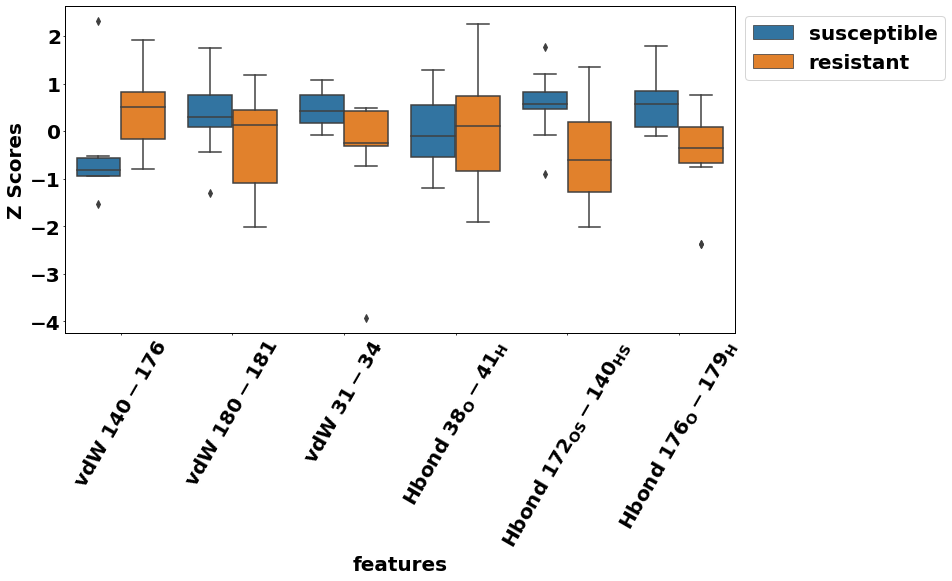

In [29]:
fig = plt.figure(figsize=(12, 6))
bplot = sns.boxplot(x='feat_label', y='val', hue='class', data=paired_boxp_df)
plt.xlabel('features')
plt.ylabel('Z Scores')
plt.legend(bbox_to_anchor=(1.0, 1.0)) 
bplot.set_xticklabels(bplot.get_xticklabels(), rotation=60)
plt.savefig('./figures/boxplot_eigenvector2.png', dpi=300, bbox_inches='tight')
plt.show()

## Conclusion

Using molecular dynamcis and ROBUST features we were able to build a model that is able to distinguish TMP susceptible and resistant variants of DHFR<sub>pj</sub>.

This is remarkable because:

**A)** There was no prior structural information on DHFR<sub>pj</sub>

**B)** Differences in binding affinity were small.

Of the 10 variants that were distinct from wildtype, only 5 showed a decrease in binding affinity that was larger than one order of magnitude.